# Свёрточная сеть: MNIST

Александр Дьяконов, 2020

#### Использованы материалы:
* https://atcold.github.io/pytorch-Deep-Learning/

In [8]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Датасет

In [2]:
input_size  = 28*28   # размер изображения
output_size = 10      # 10 классов

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

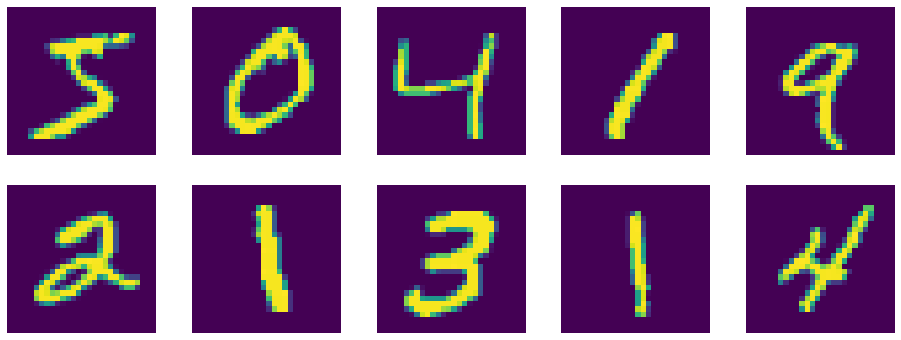

In [3]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

In [4]:
train_loader.dataset.__getitem__(0)[0].squeeze()[15:20, 15:20]

tensor([[ 1.9432,  2.7960,  2.7960,  1.4850, -0.0806],
        [-0.2206,  0.7595,  2.7833,  2.7960,  1.9560],
        [-0.4242, -0.4242,  2.7451,  2.7960,  2.7451],
        [ 1.2305,  1.9051,  2.7960,  2.7960,  2.2105],
        [ 2.7960,  2.7960,  2.7960,  2.7578,  1.8923]])

# Нейросеть

In [67]:
class Mlinear(nn.Module):
    """
    линейная
    """
    def __init__(self, input_size, output_size):
        super(Mlinear, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=28)
        # self.fc = nn.Linear(28*28, output_size)
        
    def forward(self, x, verbose=False):
        x = self.conv(x)
        x = x.view(-1, 10)
        x = F.log_softmax(x, dim=1)
        return x

In [13]:
accuracy_list = []

def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [118]:

model = Mlinear(input_size, output_size)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 3):
    train(epoch, model)
    test(model)
# Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.122960
#Test set: Average loss: 0.4662, Accuracy: 8823/10000 (88%)

Number of parameters: 14070
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.283597
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.512199
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.525875
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.345186
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.178718
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.506424
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.202364
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.322217
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.226272
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.338484

Test set: Average loss: 0.3061, Accuracy: 9151/10000 (92%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.218785
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.269072
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.366377
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.290509
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.251645
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.261202
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.258060
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.233534
Train Epoch: 1 [51200/6

## визуализируем параметры

In [121]:
# параметры модели
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

conv.weight tensor([[[[ 0.0226,  0.0314, -0.0149,  ..., -0.0147, -0.0005, -0.0037],
          [ 0.0301,  0.0315,  0.0082,  ..., -0.0155,  0.0063,  0.0263],
          [-0.0069, -0.0016,  0.0011,  ..., -0.0034,  0.0063, -0.0007],
          ...,
          [-0.0143,  0.0260,  0.0359,  ...,  0.0212, -0.0014,  0.0079],
          [-0.0086,  0.0406,  0.0243,  ...,  0.0045, -0.0114,  0.0303],
          [-0.0223,  0.0289,  0.0297,  ..., -0.0161,  0.0109,  0.0090]]],


        [[[ 0.0372, -0.0093, -0.0227,  ..., -0.0186, -0.0234, -0.0084],
          [-0.0021,  0.0118, -0.0075,  ..., -0.0204, -0.0042, -0.0095],
          [-0.0171,  0.0390, -0.0163,  ..., -0.0231,  0.0450, -0.0163],
          ...,
          [ 0.0337, -0.0048,  0.0227,  ...,  0.0343, -0.0059, -0.0232],
          [ 0.0364,  0.0253,  0.0053,  ..., -0.0078,  0.0340,  0.0336],
          [-0.0073, -0.0214,  0.0097,  ...,  0.0100,  0.0346, -0.0243]]],


        [[[ 0.0179, -0.0104, -0.0209,  ..., -0.0145, -0.0295, -0.0445],
          [ 0.

In [122]:
param.data

tensor([-0.0448,  0.0074,  0.0315,  0.0370,  0.0048,  0.0503, -0.0397,  0.0155,
         0.0160, -0.0418], device='cuda:0')

In [123]:
h = list(model.named_parameters())[0][1][2].detach().to('cpu').numpy()[0,:,:]

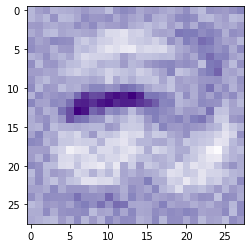

In [124]:
plt.imshow(h, cmap='Purples_r')

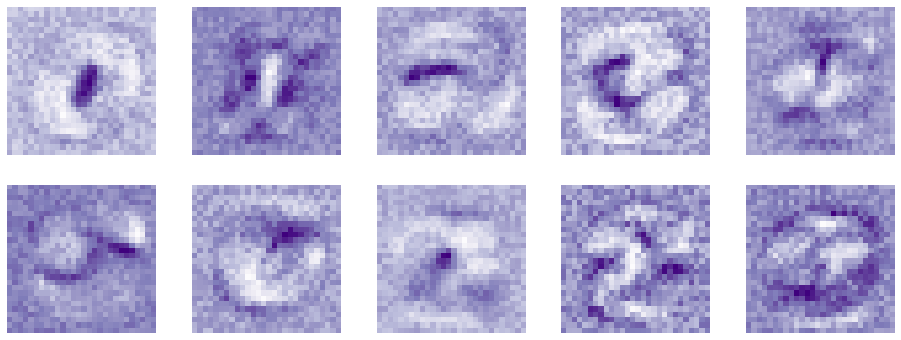

In [125]:
# выученные патерны классов
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image = list(model.named_parameters())[0][1][i].detach().to('cpu').numpy()[0,:,:]
    plt.imshow(image, cmap='Purples_r')
    plt.axis('off');

## Сложная модель

In [9]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4) # torch.flatten(x, 1 или 2)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [10]:
def get_n_params(model):
    """
    число параметров
    """
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [14]:
# Training settings 
n_features = 10 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 3):
    train(epoch, model_cnn)
    test(model_cnn)

# Test set: Average loss: 0.2849, Accuracy: 9203/10000 (92%)
# Test set: Average loss: 0.1034, Accuracy: 9679/10000 (97%)
# Test set: Average loss: 0.0784, Accuracy: 9753/10000 (98%)

Number of parameters: 11330
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.298711
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.123118
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.357951
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.267037
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.251017
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.254121
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.247766
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.222735
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.214110
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.292420

Test set: Average loss: 0.1361, Accuracy: 9603/10000 (96%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.185601
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.121008
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.135417
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.052468
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.061729
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.110413
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.115863
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.076380
Train Epoch: 1 [51200/6

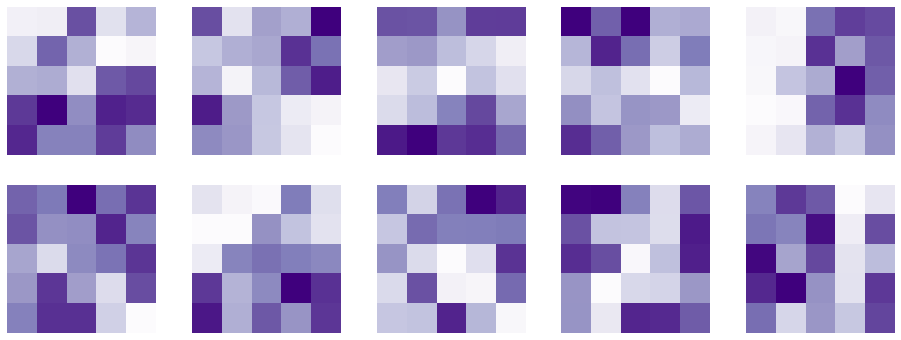

In [15]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image = list(model_cnn.named_parameters())[0][1][i].detach().to('cpu').numpy()[0,:,:]
    plt.imshow(image, cmap='Purples_r')
    plt.axis('off');

### Дополнение: как меняют размеры тензоры

In [100]:
f = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
x = torch.randn(1, 1, 28, 28)
print (x.shape)
x = f(x)
print (x.shape)
x = F.max_pool2d(x, kernel_size=2)
print (x.shape)
x = f(x)
print (x.shape)
x = F.max_pool2d(x, kernel_size=2)
print (x.shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 26, 26])
torch.Size([1, 1, 13, 13])
torch.Size([1, 1, 11, 11])
torch.Size([1, 1, 5, 5])


## Сложная модель, свёртки 3x3

In [18]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=3)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=3)
        self.fc1 = nn.Linear(n_feature*5*5, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*5*5)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [20]:
# Training settings 
n_features = 10 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 3):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 14070
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.331818
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.055310
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.538627
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.351977
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.215159
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.555545
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.221845
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.319424
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.169147
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.065263

Test set: Average loss: 0.1448, Accuracy: 9565/10000 (96%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.130074
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.156131
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.127868
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.061610
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.156055
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.246336
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.159108
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.185926
Train Epoch: 1 [51200/6

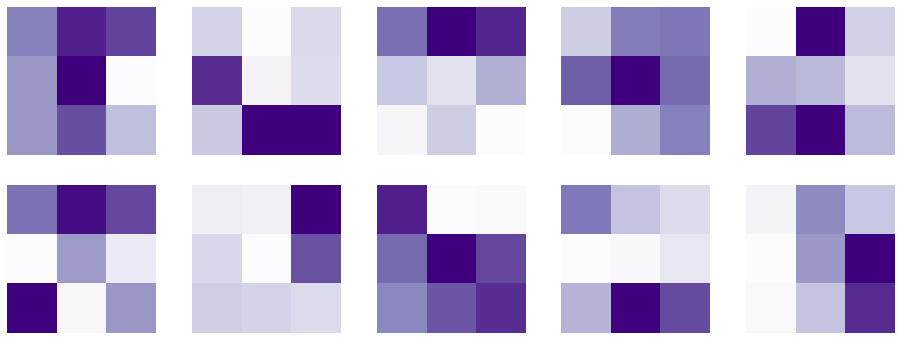

In [21]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image = list(model_cnn.named_parameters())[0][1][i].detach().to('cpu').numpy()[0,:,:]
    plt.imshow(image, cmap='Purples_r')
    plt.axis('off');

In [108]:
from torchsummary import summary
summary(model_cnn, (1, 28, 28))

ModuleNotFoundError: No module named 'torchsummary'

In [23]:
for name, param in model_cnn.named_parameters():
    if param.requires_grad:
        print (name, param.data)

conv1.weight tensor([[[[-0.0514, -0.2431, -0.1723],
          [ 0.0057, -0.3095,  0.3371],
          [ 0.0058, -0.1519,  0.1029]]],


        [[[ 0.3809,  0.6067,  0.4013],
          [-0.0851,  0.5524,  0.4146],
          [ 0.3475, -0.2006, -0.2027]]],


        [[[-0.1586, -0.4720, -0.3614],
          [ 0.1608,  0.2759,  0.0646],
          [ 0.4119,  0.1763,  0.4591]]],


        [[[ 0.1649, -0.0511, -0.0633],
          [-0.1093, -0.3075, -0.0859],
          [ 0.3718,  0.0793, -0.0369]]],


        [[[ 0.4346, -0.1011,  0.2801],
          [ 0.2101,  0.2285,  0.3284],
          [ 0.0127, -0.1007,  0.2325]]],


        [[[-0.0070, -0.2006, -0.0871],
          [ 0.4075,  0.0946,  0.3187],
          [-0.2273,  0.3887,  0.0815]]],


        [[[ 0.4000,  0.4220, -0.4082],
          [ 0.2722,  0.5044, -0.1749],
          [ 0.2318,  0.2525,  0.2803]]],


        [[[-0.2414,  0.3981,  0.3849],
          [-0.0811, -0.3138, -0.1542],
          [-0.0118, -0.1257, -0.2086]]],


        [[[ 0.1675,

# Автокодировщик

In [24]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 10),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = Autoencoder().to(device)
criterion = nn.MSELoss()

In [25]:
# Convert vector to image

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

# Displaying routine

def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

In [26]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

epoch [1/20], loss:0.5505
epoch [2/20], loss:0.4810
epoch [3/20], loss:0.5168
epoch [4/20], loss:0.4971
epoch [5/20], loss:0.4869
epoch [6/20], loss:0.5054
epoch [7/20], loss:0.4592
epoch [8/20], loss:0.5120
epoch [9/20], loss:0.4975
epoch [10/20], loss:0.5090
epoch [11/20], loss:0.4751
epoch [12/20], loss:0.4523
epoch [13/20], loss:0.5073
epoch [14/20], loss:0.4510
epoch [15/20], loss:0.5025
epoch [16/20], loss:0.5128
epoch [17/20], loss:0.4349
epoch [18/20], loss:0.4624
epoch [19/20], loss:0.4192
epoch [20/20], loss:0.5033


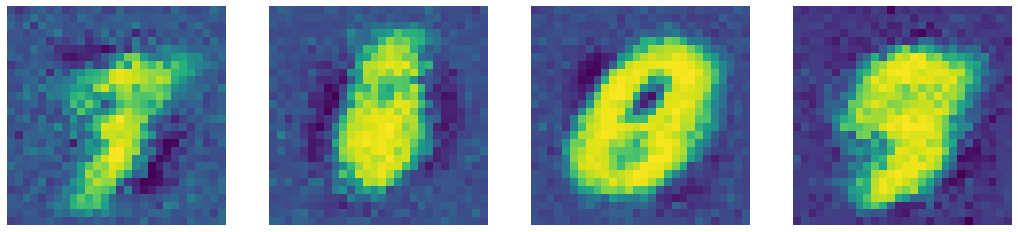

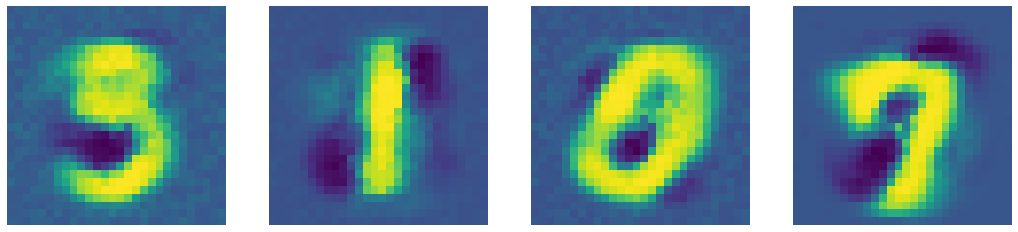

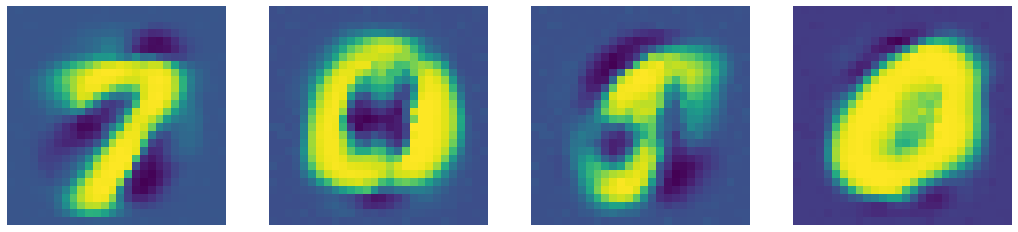

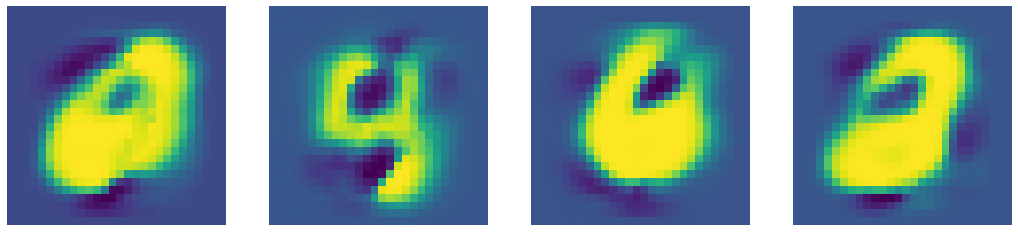

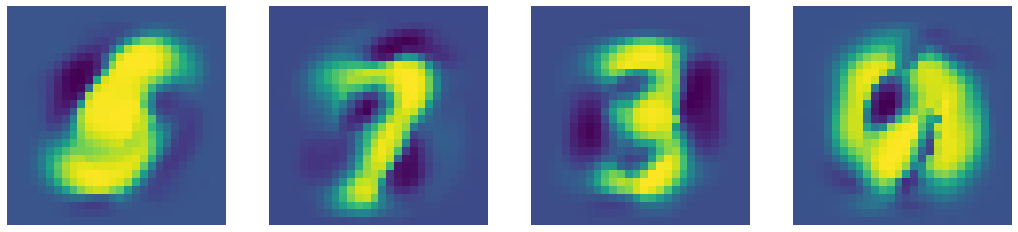

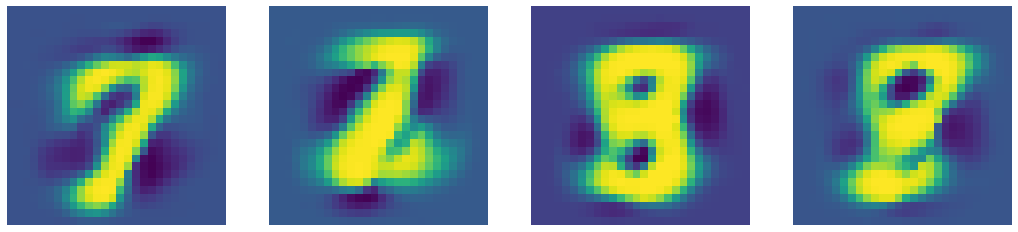

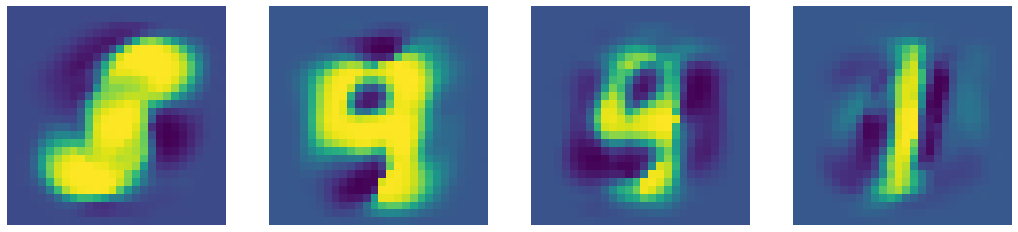

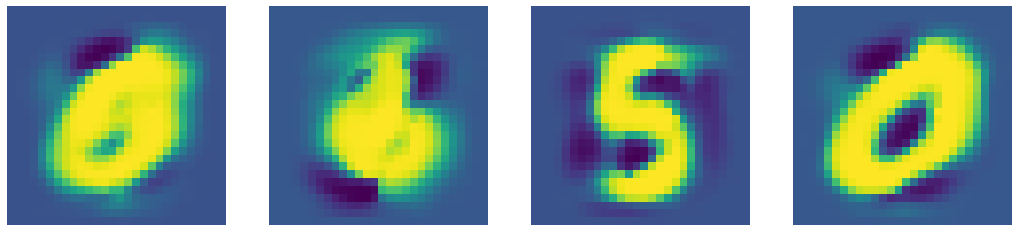

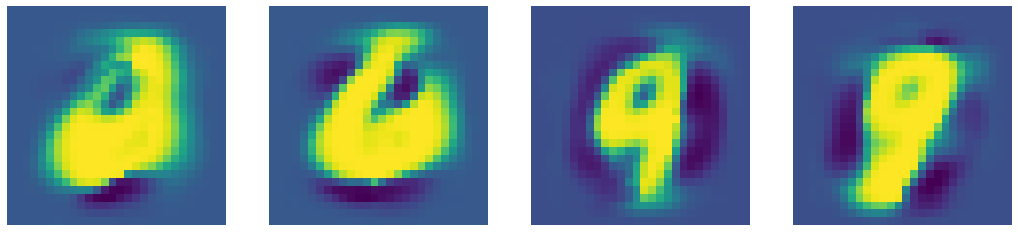

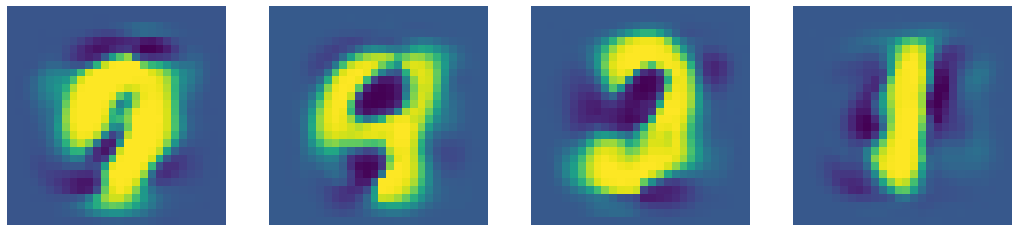

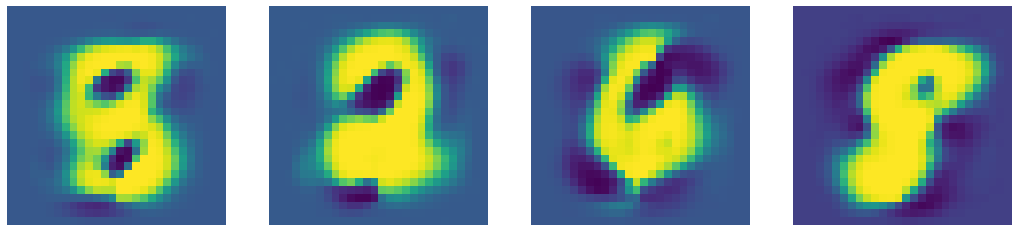

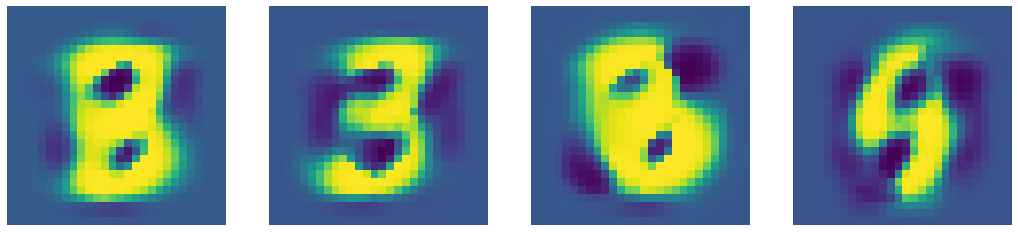

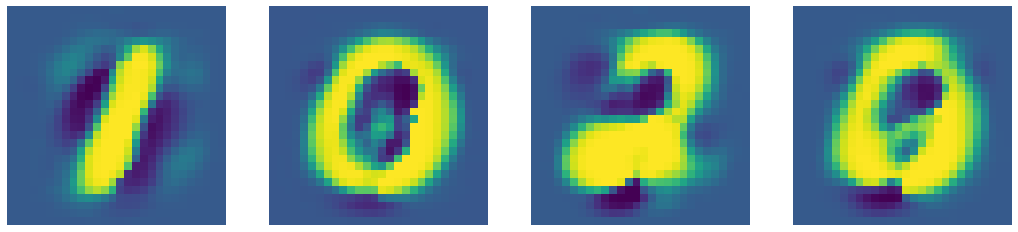

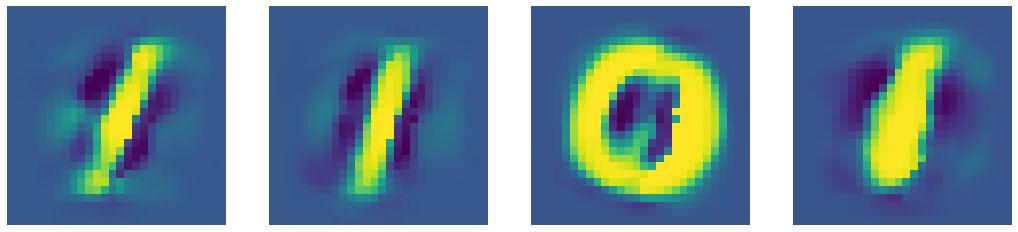

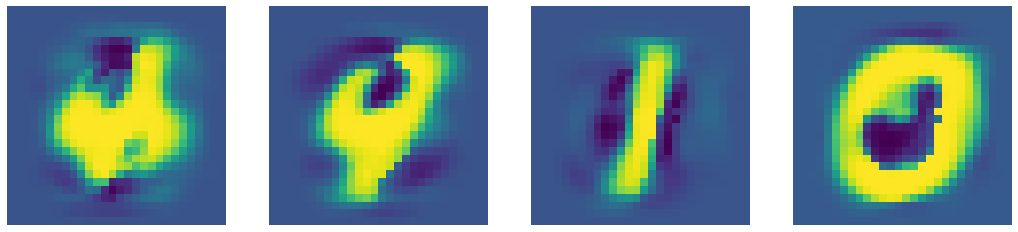

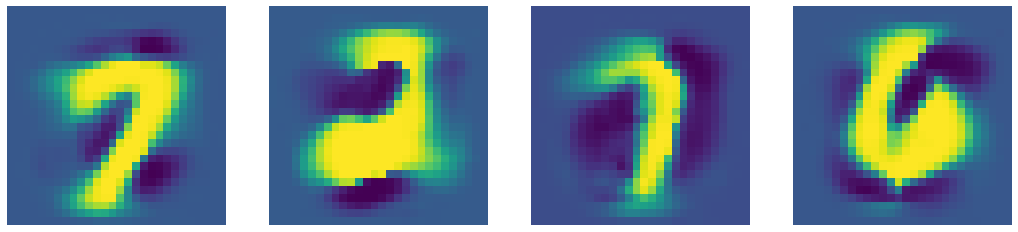

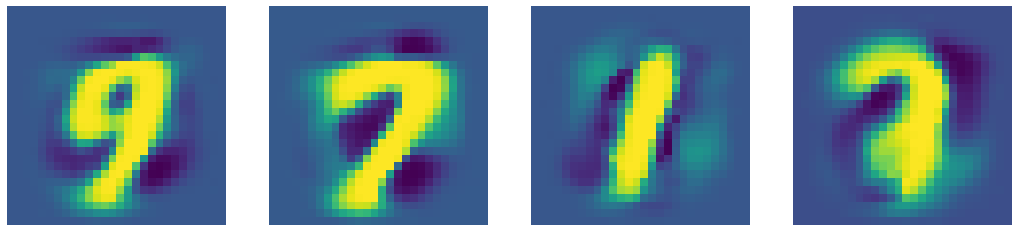

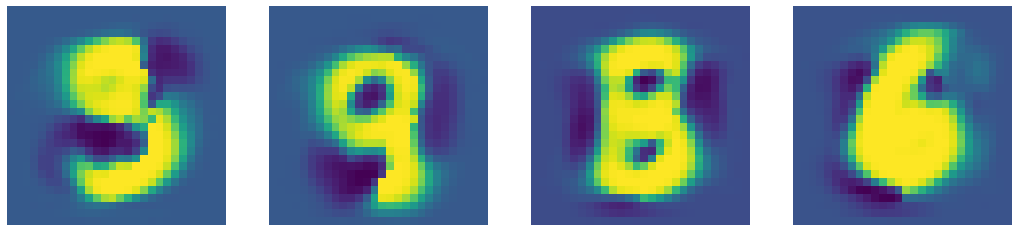

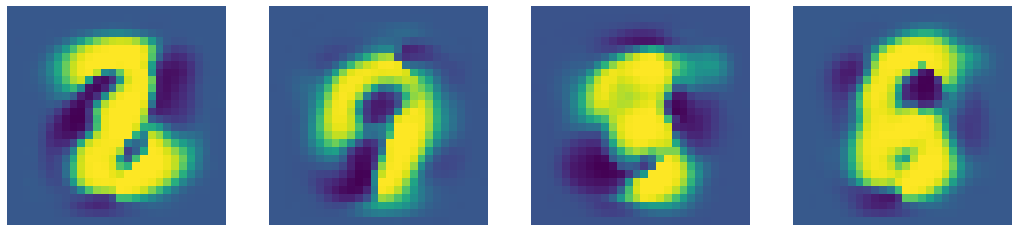

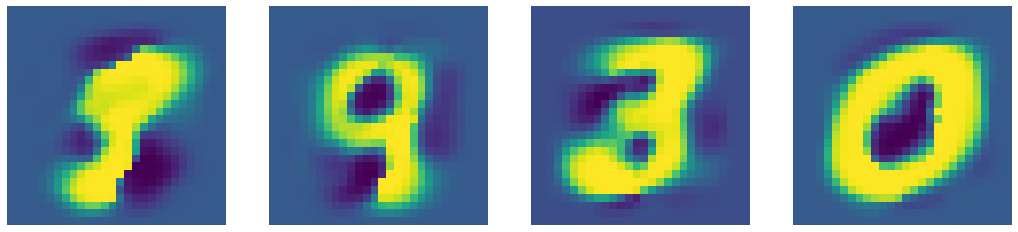

In [27]:
num_epochs = 20
# do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        # noise = do(torch.ones(img.shape)).to(device)
        # img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = model(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

# Производные по входам + DeepDream для нашего модельного случая

In [167]:
for name, param in model_cnn.named_parameters():
    if ("bn" not in name):
        param.requires_grad = False

In [168]:
x = torch.randn(1, 1, 28, 28, device=device, requires_grad=True)

In [169]:
class myDD(nn.Module):
    """
    делаем модель, у которой параметры - входное изображение
    """
    def __init__(self, model, x):
        super().__init__()
        self.weights = nn.Parameter(x)
        self.model = model
        # self.do = nn.Dropout2d(0.5)

    def forward(self):
        return self.model(self.weights)

model = myDD(model_cnn, x)

In [175]:
def trainx(nepoch, model, class2learn=0):
    """
    - сколько эпох
    - какая модель
    - на какой класс
    """
    images = []
    target = torch.tensor([class2learn]).to(device) #torch.tensor([1,0,0,0,0,0,0,0,0,0]).unsqueeze(0).to(device)
    
    # ядро для сглаживания
    cnv = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = (3,3), stride = 1, padding=1).to(device)
    cnv.weight.data = cnv.weight.data*0 + (1.0/9.0)
    cnv.bias[0] = 0.0
    
    for i in range(nepoch):
        model.train()
        optimizer.zero_grad()
        output = model()
        #print(output.shape, target.shape)        
        loss = F.nll_loss(output, target)

        loss.backward()
        optimizer.step()
        if i % 100 == 25:
            # сглаживаем
            model.weights.data = cnv(model.weights.data) 
            
        if i % 100 == 0:
            print(f'i={i} loss={loss}')
            images.append(model.weights.squeeze().detach().cpu())
    return images

In [176]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
images = trainx(1000, model, class2learn=0)

i=0 loss=0.7772314548492432
i=100 loss=0.00047588348388671875
i=200 loss=0.00027561187744140625
i=300 loss=0.0002117156982421875
i=400 loss=0.000156402587890625
i=500 loss=0.000125885009765625
i=600 loss=0.00010585784912109375
i=700 loss=9.250640869140625e-05
i=800 loss=8.296966552734375e-05
i=900 loss=7.534027099609375e-05


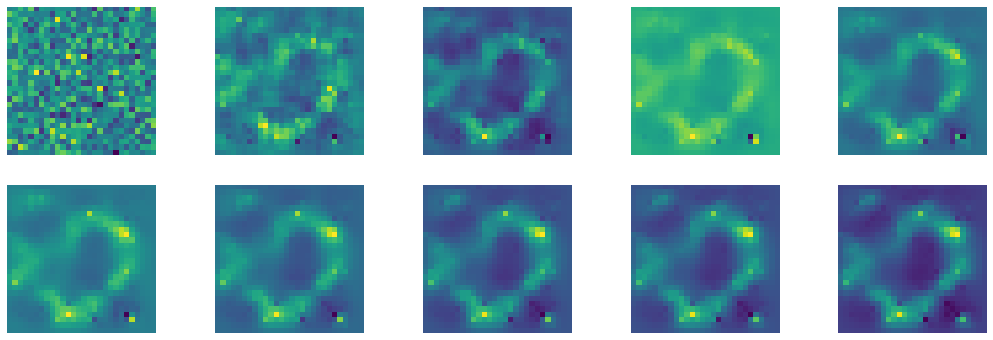

In [180]:
plt.figure(figsize=(18, 6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i])
    # (f'i = {i*100}')
    plt.axis('off')

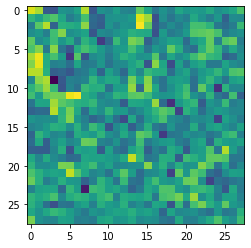

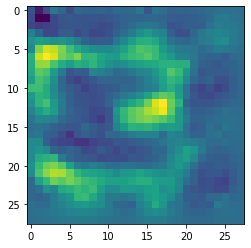

In [166]:
plt.imshow(x.squeeze().detach().cpu())
plt.show()
plt.imshow(model.weights.squeeze().detach().cpu())

i=0 loss=0.00019741058349609375
i=100 loss=0.0001697540283203125
i=200 loss=0.00014209747314453125
i=300 loss=0.0001316070556640625
i=400 loss=0.0001201629638671875
i=500 loss=0.000110626220703125
i=600 loss=0.0001010894775390625
i=700 loss=8.487701416015625e-05
i=800 loss=8.106231689453125e-05
i=900 loss=7.2479248046875e-05


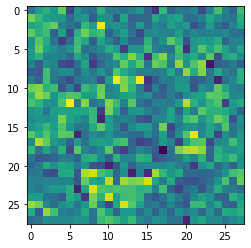

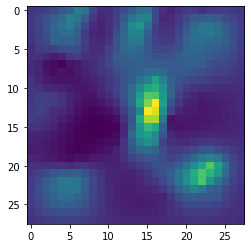

In [182]:
trainx(1000, model, class2learn=1)
plt.imshow(x.squeeze().detach().cpu())
plt.show()
plt.imshow(model.weights.squeeze().detach().cpu())